# ISCE2 Setup
<br>

This notebook is an interactive jupyter playground to set up your system and get the required files to generate dense ofsets using ISCE2. 

>**DISCLAIMER:** The setup for ISCE2 varies by system and is a very frustrating process.
>You will likely run into errors, refer to the UNAVCO tutorials from [2021](https://github.com/parosen/Geo-SInC/blob/main/UNAVCO2021/4.4_Offset_stack_for_velocity_dynamics/nb_topsApp_offsets.ipynb) and [2024](https://github.com/parosen/Geo-SInC/blob/main/EarthScope2024/4.3_Offset_stack_for_velocity_dynamics_with_autoRIFT/nb_dense_offsets.ipynb) for other setup and debugging tips.

This notebook contains 3 steps:
1. Ensure proper file strucure
2. Downloading DEM
3. Clone orbit script

Once you run through this notebook and feel comfortable with the process, you can modify the contents of `./offsets/run_isce2.py` to automate the process.

### Import Packages

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pdemtools as pdt
import rasterio
import xarray as xr
from osgeo import gdal, osr
from pyproj import Transformer
from rasterio.transform import Affine
from shapely import wkt
from shapely.ops import transform
from pyproj import Transformer

### Helper Functions

In [2]:
# Step 4: Create and save the DEM file with proper georeference
def save_dem_with_projection(dem, output_file, source_crs, target_crs):
    """
    Create a georeferenced DEM raster from an xarray DataArray and reproject it.

    Parameters
    ----------
    dem : xarray.DataArray
        2D DEM array with coordinates `dem.x` and `dem.y`, representing
        map-projected grid coordinates. Must contain numeric elevation values.
    output_file : str
        Path to the output DEM file to be written in ENVI format (e.g., "*.dem").
    source_crs : str
        CRS of the input DEM, in "EPSG:xxxx" format (e.g., "EPSG:3031").
    target_crs : str
        CRS to reproject into (e.g., "EPSG:4326" for WGS84).
    
    Returns
    -------
    str
        Path to the final reprojected DEM file (same as `output_file`).

    Notes
    -----
    - Builds an ENVI raster with a proper GDAL geotransform based on the DEM's
      x/y coordinate spacing.
    - Handles decreasing y-coordinates by flipping the sign of pixel height.
    - Writes the DEM to disk, then uses GDAL Warp to reproject into `target_crs`.
    - The warped file replaces the original output to keep a single final product.
    """
    # Get dimensions and values
    height, width = dem.shape
    
    # Create a geotransform (origin_x, pixel_width, 0, origin_y, 0, pixel_height)
    # Note: In the screenshot, y values appear to be decreasing (1.773e6 to 1.636e6)
    x_min = dem.x.values[0]
    y_max = dem.y.values[0]
    x_res = abs((dem.x.values[-1] - dem.x.values[0]) / (len(dem.x) - 1))
    y_res = abs((dem.y.values[-1] - dem.y.values[0]) / (len(dem.y) - 1))
    
    # Adjust y_res sign if y is decreasing
    if dem.y.values[0] > dem.y.values[-1]:
        y_res = -y_res
    
    # Create geotransform
    geotransform = (x_min, x_res, 0, y_max, 0, y_res)
    
    # Create output dataset
    driver = gdal.GetDriverByName('ENVI')
    dataset = driver.Create(
        output_file,
        width,
        height,
        1,  # Number of bands
        gdal.GDT_Float32  # Data type (float32 based on your data)
    )
    
    # Set geotransform and projection
    dataset.SetGeoTransform(geotransform)
    
    # Set source projection
    source_srs = osr.SpatialReference()
    source_srs.ImportFromEPSG(int(source_crs.split(':')[1]))
    dataset.SetProjection(source_srs.ExportToWkt())
    
    # Fill with data
    dataset.GetRasterBand(1).WriteArray(dem.values)
    dataset.GetRasterBand(1).SetNoDataValue(float(dem.attrs.get('_FillValue', -9999.0)))
    
    # Flush to disk
    dataset = None
    
    # Now create a warped version in WGS84
    wgs84_file = output_file.replace('.dem', '_wgs84.dem')
    warp_options = gdal.WarpOptions(
        srcSRS=source_crs,
        dstSRS=target_crs,
        resampleAlg=gdal.GRA_Bilinear
    )
    
    gdal.Warp(wgs84_file, output_file, options=warp_options)
    
    # Replace original file with warped version
    os.replace(wgs84_file, output_file)
    
    return output_file

# Step 5: Create an associated VRT file
def create_vrt_file(dem_file, vrt_file):
    """
    Create a GDAL VRT (Virtual Raster) referencing an existing DEM file.

    Parameters
    ----------
    dem_file : str
        Path to the DEM raster file to be referenced.
    vrt_file : str
        Filename for the output VRT file.

    Returns
    -------
    str
        Path to the created VRT file.

    Notes
    -----
    VRTs store metadata and band references without duplicating raster data.
    Useful for workflows that require GDAL-readable metadata sidecar files.
    """
    # Open the DEM to get its properties
    ds = gdal.Open(dem_file)
    
    # Create the VRT
    vrt_ds = gdal.BuildVRT(vrt_file, [dem_file])
    vrt_ds = None
    
    return vrt_file

# Step 6: Create an associated XML metadata file
def create_xml_metadata(dem_file, xml_file, dem):
    """
    Write an XML metadata sidecar file describing the DEM dataset.

    Parameters
    ----------
    dem_file : str
        Path to the DEM file the metadata describes.
    xml_file : str
        Output XML filename.
    dem : xarray.DataArray
        DEM dataset providing dimensions and attributes.

    Returns
    -------
    str
        Path to the written XML file.

    Notes
    -----
    - Includes dataset name, x/y dimensions, and all attributes in `dem.attrs`.
    - Adds a fixed 'WGS84' spatial reference tag (adjust if needed).
    - XML schema is simple and intended for external tools that expect an ASF-
      style metadata block.
    """
    with open(xml_file, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write('<metadata>\n')
        f.write('  <dataset>\n')
        f.write(f'    <name>{os.path.basename(dem_file)}</name>\n')
        
        # Add dimensions
        f.write('    <dimensions>\n')
        f.write(f'      <x>{len(dem.x)}</x>\n')
        f.write(f'      <y>{len(dem.y)}</y>\n')
        f.write('    </dimensions>\n')
        
        # Add attributes from the xarray
        f.write('    <attributes>\n')
        for key, value in dem.attrs.items():
            f.write(f'      <{key}>{value}</{key}>\n')
        f.write('    </attributes>\n')
        
        # Add spatial reference
        f.write('    <spatial_reference>WGS84</spatial_reference>\n')
        
        f.write('  </dataset>\n')
        f.write('</metadata>\n')
    
    return xml_file

## Step 1: Verify File Structure

This repository was cloned with the following file structure:

```
crevasse-advection/
├── figures/
├── offsets/
│   ├── aux/
│   ├── dem/
│   ├── orbits/
│   ├── SAFE/
│   └── run_isce2.py
├── 01-ISCE2_steup.ipynb
├── 02-run_topsApp.ipynb
├── 03-offset_postprocessing.ipynb
├── 04-derive_stress.ipynb
├── 05-advection_tracking.ipynb
├── 06-timeseries_decomposition.ipynb
├── isce_requirements.txt
├── environment.yml
└── README.md
```

When ISCE2 runs, it creates dozens of extra files and folders, which can get messy very fast. 
To contain the clutter, offsets will be generated from offsets folder, `./offsets/`

Since we plan to make a timeseries of offsets. 
To further contain the files, each offset will be print to its own folder named by the two dates, `./offsets/YYYYMMDD-YYYYMMDD`.
By the end of processing, your directory will look something like:

```
offsets/
├── aux/
├── dem/
├── orbits/
├── SAFE/
├── 20201010-20201022/
│   ├── fine_offsets/
│   └── topsApp.xml
├── 20201022-20201103/
│   ├── fine_offsets/
│   └── topsApp.xml
└── run_isce2.py
```

In [3]:
os.chdir('offsets/')
os.listdir()

['run_isce2.py',
 'aux',
 'dem',
 'orbits',
 'SAFE',
 '.ipynb_checkpoints',
 'fetchOrbit.py']

## Step 2: Getting a DEM

ISCE2 requires a DEM to coregister different Sentinel-1 images. We can use the Python package `pdemtools` to download and save a REMA in the format ISCE2 expects.

In [4]:
# . . Convert polygon for Shirase Glacier form EPSG:4326 to EPSG:3031
wkt_str = "POLYGON((38.5117 -70.9317,41.8808 -69.9783,39.6027 -69.0519,36.2888 -69.9576,38.5117 -70.9317))"

# Shapely geometry
polygon_wgs84 = wkt.loads(wkt_str)

# Transformer: 4326 to 3031, with lon/lat ordering
tfm = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True).transform

# One-line geometry transform
polygon_3031 = transform(tfm, polygon_wgs84)

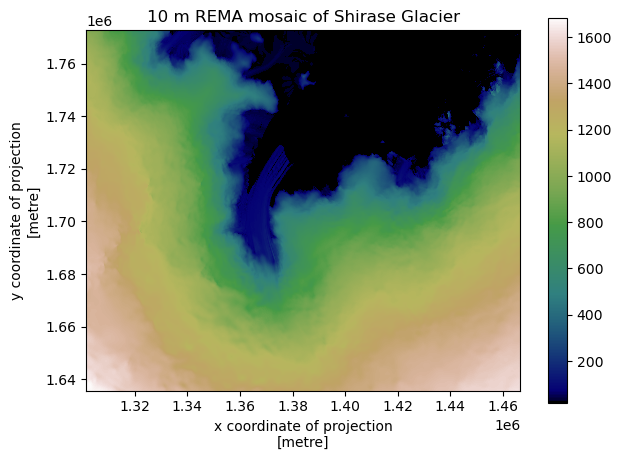

In [5]:
# . . Use pdemtools to load DEM mosaic from the polygon
dem = pdt.load.mosaic(
    dataset='rema',       # must be `arcticdem` or `rema`
    resolution=10,        # must be 2, 10, or 32
    bounds=polygon_3031,  # (xmin, ymin, xmax, ymax) or a shapely geometry
    version='v2.0',       # optional: desired version (defaults to most recent)
)

# . . Plot the DEM to check ROI
fig, ax = plt.subplots(figsize=(7, 5))

dem.plot.imshow(ax=ax, cmap='gist_earth')

ax.set_aspect('equal')
ax.set_title('10 m REMA mosaic of Shirase Glacier')
plt.show()

### Convert DEM to EPSG:4326

ISCE2 requires the DEM to be in EPSG:4326. In the following cells, we will convert the REMA DEM from above to the right CRS and write to an ENVI raster with the appropriate metadata files.

In [9]:
# . . Set source and target refernce systems
source_crs = 'EPSG:3031'  # Antarctic Polar Stereographic
target_crs = 'EPSG:4326'  # WGS84

# Define output filenames
output_base = "./dem/shirase_dem"
dem_file = f"{output_base}.dem"
vrt_file = f"{output_base}.vrt"
xml_file = f"{output_base}.xml"

# . . Call write functions
# Save the DEM file with WGS84 projection
print(f"Saving DEM file to {dem_file}...")
save_dem_with_projection(dem, dem_file, source_crs, target_crs)

# Create VRT file
print(f"Creating VRT file {vrt_file}...")
create_vrt_file(dem_file, vrt_file)

# Create XML metadata file
print(f"Creating XML metadata file {xml_file}...")
create_xml_metadata(dem_file, xml_file, dem)

print("Conversion complete!")
    
# For verification, read back the DEM file to check its properties
ds = gdal.Open(dem_file)
if ds:
    print("\nVerification:")
    print(f"Size: {ds.RasterXSize}x{ds.RasterYSize}")
    print(f"Projection: {ds.GetProjection()}")
    print(f"GeoTransform: {ds.GetGeoTransform()}")
    
    # Read a sample of data
    band = ds.GetRasterBand(1)
    data_sample = band.ReadAsArray(0, 0, 10, 10)
    print(f"Data sample (10x10):\n{data_sample}")
    
    ds = None

Saving DEM file to ./dem/shirase_dem.dem...
Creating VRT file ./dem/shirase_dem.vrt...
Creating XML metadata file ./dem/shirase_dem.xml...
Conversion complete!

Verification:
Size: 21447x7210
Projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GeoTransform: (36.28862853067194, 0.0002607532777777778, 0.0, -69.05180701485756, 0.0, -0.0002607532777777778)
Data sample (10x10):
[[-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767]
 [-32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -32767 -327

## Step 3: Clone Orbits Script

One of the necessary input files for ISCE2 is the precise orbit file for a given satellite pass. 
ISCE2 has a Python script in the `topsStack` module, but not in the `topsApp` module. This script will download the necessary orbit files from the Copernicus database when run.

In [10]:
%%bash

wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
chmod +x fetchOrbit.py

File ‘fetchOrbit.py’ already there; not retrieving.



Once you download the file, go to lines 134 and 135 and change them to your username and password for the Copernicus data ecosystem. 

```python
if __name__ == '__main__':
    '''
    Main driver.
    '''

    inps = cmdLineParse()
    username = inps.username  # Change to your username
    password = inps.password  # Change to your password
    token_file = os.path.expanduser(inps.token_file)
```